   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.3 MB/s eta 0:00:00
Center: 03h17m12.61s +41d20m52.64s
HST F814W rows: 13
Selected obs_id: hst_skycell-p2166x06y08_acs_wfc_f814w_all | inst: ACS/WFC | calib: 3 | expt: 4630.0
Chosen product: hst_skycell-p2166x06y08_acs_wfc_f814w_all_drc.fits | subgroup: DRC | size: 1584089280.0
Resolved local FITS: ./mastDownload/HST/hst_skycell-p2166x06y08_acs_wfc_f814w_all/hst_skycell-p2166x06y08_acs_wfc_f814w_all_drc.fits
Cutout: (7500, 7500) | pixscale≈0.04000 arcsec/pix
mask: median=0.049508 | sigma~0.00526525 | thr=0.0758342 | masked fraction=0.030


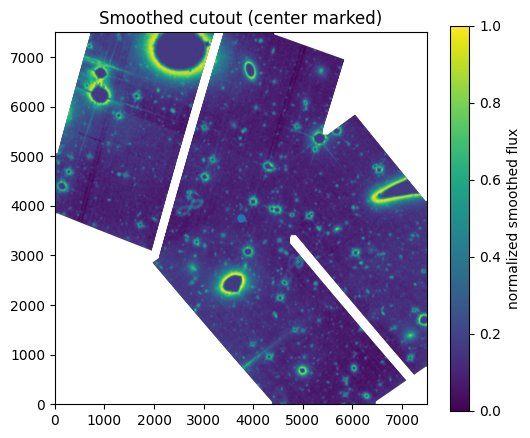


Baseline Ahat(center): -0.0017596220519570107
Local candidates: 21205704 | N_local: 800
LOCAL control on Ahat: p_low=0.399 | p_high=0.601
Ahat median: -0.0010647072608000712 | std: 0.03524520562681965
5%,95%: [-0.004370246674148522, 0.006200152468052559]


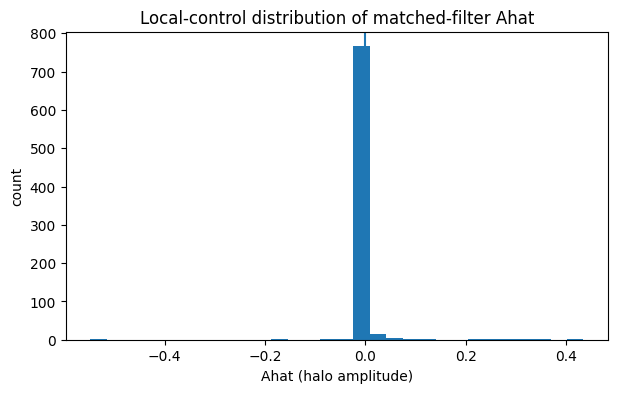


DONE.


In [1]:
# --- ONE-CELL RAM-SAFE RESTART (FIXED PATH RESOLUTION) ---
!pip -q install "astroquery>=0.4.7" astropy scipy numpy matplotlib

import os, glob, gc
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astroquery.mast import Observations
from scipy.ndimage import gaussian_filter

# ---------------------------
# CONFIG
# ---------------------------
center = SkyCoord("03h17m12.61s +41d20m52.64s")
radius = 3.5 * u.arcmin
FILT = "F814W"

CUTOUT_ARCSEC = 300.0        # 300" => ~7500 px at 0.04"/px
SMOOTH_SIGMA_PIX = 12.0
HALO_SIGMA_ARCSEC = 10.0

LC_R1_ARCSEC = 60.0
LC_R2_ARCSEC = 120.0
N_LOCAL = 800

SIGMA_CLIP = 5.0

# ---------------------------
# HELPERS
# ---------------------------
def robust_median_sigma(a):
    a = a[np.isfinite(a)]
    med = np.median(a)
    mad = np.median(np.abs(a - med))
    sigma = 1.4826 * mad if mad > 0 else np.std(a)
    return med, sigma

def pixscale_arcsec_per_pix(wcs):
    cd = wcs.pixel_scale_matrix  # deg/pix
    s1 = np.sqrt(cd[0,0]**2 + cd[0,1]**2)
    s2 = np.sqrt(cd[1,0]**2 + cd[1,1]**2)
    return float(np.sqrt(s1*s2) * 3600.0)

def build_template(nx, ny, cx, cy, sigma_pix):
    y, x = np.mgrid[0:ny, 0:nx]
    r2 = (x - cx)**2 + (y - cy)**2
    t = np.exp(-0.5 * r2 / (sigma_pix**2))
    t = t - np.nanmean(t)
    return t.astype(np.float32)

def fit_Ahat_with_plane(img, tmpl):
    ny, nx = img.shape
    y, x = np.mgrid[0:ny, 0:nx]
    valid = np.isfinite(img) & np.isfinite(tmpl)
    vv = np.where(valid.ravel())[0]
    if vv.size < 2000:
        return np.nan
    X = np.vstack([
        tmpl.ravel()[vv],
        x.ravel()[vv].astype(float),
        y.ravel()[vv].astype(float),
        np.ones_like(vv, dtype=float)
    ]).T
    b = img.ravel()[vv].astype(float)
    beta, *_ = np.linalg.lstsq(X, b, rcond=None)
    return float(beta[0])

def sample_local_centers(ny, nx, cx0, cy0, pixscale, r1_arc, r2_arc, N, rng):
    y, x = np.mgrid[0:ny, 0:nx]
    r_arc = np.sqrt((x - cx0)**2 + (y - cy0)**2) * pixscale
    cand = np.where((r_arc >= r1_arc) & (r_arc <= r2_arc))
    if cand[0].size < 1000:
        return None, None, cand[0].size
    idx = rng.integers(0, cand[0].size, size=N)
    cy = cand[0][idx].astype(float)
    cx = cand[1][idx].astype(float)
    return cx, cy, cand[0].size

def p_low(A0, As):
    As = np.array(As, dtype=float)
    As = As[np.isfinite(As)]
    return float(np.mean(As <= A0)), float(np.mean(As >= A0))

# ---------------------------
# 1) QUERY OBS
# ---------------------------
print("Center:", center.to_string('hmsdms'))
obs = Observations.query_region(center, radius=radius)
obs = obs[(obs["obs_collection"] == "HST")]
filt = np.array(obs["filters"]).astype(str)
obs = obs[np.char.find(filt, FILT) >= 0]
print("HST F814W rows:", len(obs))
if len(obs) == 0:
    raise RuntimeError("No HST F814W observations found in this radius.")

# pick best by exptime, then calib
expt = np.array(obs["t_exptime"]).astype(float)
cal  = np.array(obs["calib_level"]).astype(int)
order = np.lexsort((-expt, -cal))
obs = obs[order]
row = obs[0]
print(f"Selected obs_id: {row['obs_id']} | inst: {row['instrument_name']} | calib: {row['calib_level']} | expt: {row['t_exptime']}")

# ---------------------------
# 2) PRODUCTS -> pick largest DRC/DRZ
# ---------------------------
prod = Observations.get_product_list(row)
prod = Observations.filter_products(prod, productSubGroupDescription=["DRC","DRZ"], extension="fits")
if "dataRights" in prod.colnames:
    prod = prod[np.array(prod["dataRights"]).astype(str) == "PUBLIC"]
if len(prod) == 0:
    raise RuntimeError("No DRC/DRZ fits product found for this observation.")

sizes = np.array(prod["size"]).astype(float)
sizes = np.where(np.isfinite(sizes), sizes, 0.0)
chosen = prod[np.argmax(sizes)]
print("Chosen product:", chosen["productFilename"], "| subgroup:", chosen["productSubGroupDescription"], "| size:", float(chosen["size"]))

# download
dl = Observations.download_products(chosen, mrp_only=False)

# ---- robust local file resolution (fix) ----
# Most reliable: look inside the created download directory for *.fits
# astroquery uses ./mastDownload by default
download_root = "./mastDownload"
fits_files = sorted(glob.glob(os.path.join(download_root, "**", "*.fits"), recursive=True))

# Narrow search: filename match preferred
target_name = str(chosen["productFilename"])
cand = [p for p in fits_files if os.path.basename(p) == target_name]
if len(cand) > 0:
    local_path = cand[0]
else:
    # fallback: newest fits file
    if len(fits_files) == 0:
        raise RuntimeError("Download seems to have succeeded but no .fits found under ./mastDownload.")
    local_path = max(fits_files, key=os.path.getmtime)

print("Resolved local FITS:", local_path)

# ---------------------------
# 3) LOAD FITS + CUTOUT (SCI)
# ---------------------------
with fits.open(local_path, memmap=True) as hdul:
    hdu_name = "SCI" if "SCI" in hdul else 1
    hdu = hdul[hdu_name]
    data = hdu.data.astype(np.float32)
    wcs = WCS(hdu.header)

pixscale = pixscale_arcsec_per_pix(wcs)
size_pix = int(round(CUTOUT_ARCSEC / pixscale))
cut = Cutout2D(data, position=center, size=(size_pix, size_pix), wcs=wcs, mode="partial", fill_value=np.nan)
img = cut.data.astype(np.float32)
ny, nx = img.shape
cy0, cx0 = (ny-1)/2.0, (nx-1)/2.0
print(f"Cutout: {img.shape} | pixscale≈{pixscale:.5f} arcsec/pix")

del data
gc.collect()

# ---------------------------
# 4) MASK + SMOOTH
# ---------------------------
med, sig = robust_median_sigma(img)
thr = med + SIGMA_CLIP * sig
mask = (img > thr) & np.isfinite(img)
masked_frac = float(np.mean(mask))
print(f"mask: median={med:.6g} | sigma~{sig:.6g} | thr={thr:.6g} | masked fraction={masked_frac:.3f}")

filled = img.copy()
filled[mask] = med
sm = gaussian_filter(filled, SMOOTH_SIGMA_PIX).astype(np.float32)

plt.figure(figsize=(6,5))
plt.imshow((sm - np.nanmin(sm)) / (np.nanmax(sm)-np.nanmin(sm) + 1e-12), origin="lower")
plt.scatter([cx0],[cy0], s=25)
plt.title("Smoothed cutout (center marked)")
plt.colorbar(label="normalized smoothed flux")
plt.show()

# ---------------------------
# 5) MATCHED FILTER Ahat (center)
# ---------------------------
halo_sigma_pix = HALO_SIGMA_ARCSEC / pixscale
tmpl0 = build_template(nx, ny, cx0, cy0, halo_sigma_pix)
A0 = fit_Ahat_with_plane(sm, tmpl0)
print("\nBaseline Ahat(center):", A0)

# ---------------------------
# 6) LOCAL CONTROL (60-120")
# ---------------------------
rng = np.random.default_rng(123)
cx_s, cy_s, n_cand = sample_local_centers(ny, nx, cx0, cy0, pixscale, LC_R1_ARCSEC, LC_R2_ARCSEC, N_LOCAL, rng)
print("Local candidates:", n_cand, "| N_local:", N_LOCAL)
if cx_s is None:
    raise RuntimeError("Too few local candidates; increase cutout or widen local annulus.")

As = []
for i in range(N_LOCAL):
    tmpl = build_template(nx, ny, cx_s[i], cy_s[i], halo_sigma_pix)
    As.append(fit_Ahat_with_plane(sm, tmpl))
    if (i+1) % 100 == 0:
        gc.collect()

pl, ph = p_low(A0, As)
As = np.array(As, dtype=float)
q05, q95 = np.nanpercentile(As[np.isfinite(As)], [5,95])
print(f"LOCAL control on Ahat: p_low={pl:.3f} | p_high={ph:.3f}")
print("Ahat median:", float(np.nanmedian(As)), "| std:", float(np.nanstd(As)))
print("5%,95%:", [float(q05), float(q95)])

plt.figure(figsize=(7,4))
plt.hist(As[np.isfinite(As)], bins=30)
plt.axvline(A0)
plt.title("Local-control distribution of matched-filter Ahat")
plt.xlabel("Ahat (halo amplitude)")
plt.ylabel("count")
plt.show()

print("\nDONE.")